In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from models.mnist_nets import deep_net

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using {device}")

using cuda


In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
# Constants

history_step = 15
output_step = 100

In [4]:
# Hyperparameters

batch_size = 128
epochs = 5

In [5]:
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print(f"Number of batches: {len(train_dataloader)}")

Number of batches: 469


In [6]:
optimizers = [
    torch.optim.SGD,
    torch.optim.Adam,
    torch.optim.RMSprop
]

lrs = [0.01, 0.001, 0.01]

num_opts = len(optimizers)

In [7]:
from copy import deepcopy
model = deep_net(28*28, 10).to(device)
models = [deepcopy(model) for _ in range(num_opts)]
model_for_l2o = deepcopy(model)
model_for_gnn = deepcopy(model)

In [8]:
loss_fn = nn.CrossEntropyLoss()

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    history = []
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.item()

        if batch % output_step == 0:
            current = batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            

        if batch % history_step == 0:
            history.append(loss)
            
    return history

In [10]:
his = [[] for _ in range(num_opts)]
for i in range(num_opts):
    print(f"Using {optimizers[i].__name__}")
    for t in range(epochs):
        print(f"Epoch {t+1}: ")
        
        loss = train(
            train_dataloader,
            models[i],
            loss_fn,
            optimizers[i](models[i].parameters(), lr=lrs[i]))

        his[i].append(loss)

    print("Done!\n")

Using SGD
Epoch 1: 
loss: 2.311872  [    0/60000]
loss: 2.199598  [12800/60000]
loss: 1.969465  [25600/60000]
loss: 1.603737  [38400/60000]
loss: 1.351630  [51200/60000]
Epoch 2: 
loss: 1.200153  [    0/60000]
loss: 1.012552  [12800/60000]
loss: 0.944121  [25600/60000]
loss: 0.881503  [38400/60000]
loss: 0.871036  [51200/60000]
Epoch 3: 
loss: 0.795856  [    0/60000]
loss: 0.703463  [12800/60000]
loss: 0.731905  [25600/60000]
loss: 0.724740  [38400/60000]
loss: 0.747432  [51200/60000]
Epoch 4: 
loss: 0.658446  [    0/60000]
loss: 0.593638  [12800/60000]
loss: 0.641799  [25600/60000]
loss: 0.648551  [38400/60000]
loss: 0.693341  [51200/60000]
Epoch 5: 
loss: 0.575444  [    0/60000]
loss: 0.529051  [12800/60000]
loss: 0.585773  [25600/60000]
loss: 0.592317  [38400/60000]
loss: 0.654391  [51200/60000]
Done!

Using Adam
Epoch 1: 
loss: 2.311872  [    0/60000]
loss: 0.570264  [12800/60000]
loss: 0.502003  [25600/60000]
loss: 0.467036  [38400/60000]
loss: 0.533552  [51200/60000]
Epoch 2: 
lo

In [11]:
for i in range(num_opts):
    his[i] = torch.tensor(his[i]).reshape(-1)

## Using L2O Optimizer

In [12]:
from models.optim_nets import lstm_l2o_optimizer   
from trainUtil import init_hidden, zero_gradients

In [13]:
l2o_optimizer = lstm_l2o_optimizer().to(device)
l2o_optimizer.load_state_dict(torch.load("trained_model/l2o_optimizer.pth"))
l2o_optimizer.eval()

lstm_l2o_optimizer(
  (LSTM): LSTM(1, 24, num_layers=2)
  (linear): Linear(in_features=24, out_features=1, bias=True)
)

In [14]:
def update_weights(model, update_fn, hidden):
    with torch.no_grad():
        for m_key in model._modules:
            m1 = model._modules[m_key]
            h_module = hidden[m_key]
            for p_key in m1._parameters:
                
                grad_in = m1._parameters[p_key].grad.reshape(1, -1, 1)

                update, h_module[p_key] = update_fn(grad_in, h_module[p_key])        
                update = update.reshape(m1._parameters[p_key].shape)
                
                m1._parameters[p_key] -= update 

In [15]:
def train_with_l2o(dataloader, model, loss_fn, l2o_optimizer):
    h = init_hidden(model)
    size = len(dataloader.dataset)
    history = []
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        # Preprocessing
        X, y = X.to(device), y.to(device)

        # Forward Pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backprop
        zero_gradients(model)
        loss.backward()
        update_weights(model, l2o_optimizer, h)

        loss = loss.item()

        if batch % output_step == 0:
            current = batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            

        if batch % history_step == 0:
            history.append(loss)

    return history

In [16]:
l2o_hist = []
for i in range(epochs):
    print(f"Epoch: {i + 1}")
    loss = train_with_l2o(
        train_dataloader,
        model_for_l2o,
        loss_fn,
        l2o_optimizer)

    l2o_hist.append(loss)


Epoch: 1
loss: 2.311872  [    0/60000]
loss: 0.897103  [12800/60000]
loss: 0.743096  [25600/60000]
loss: 0.651581  [38400/60000]
loss: 0.678299  [51200/60000]
Epoch: 2
loss: 0.441447  [    0/60000]
loss: 0.562318  [12800/60000]
loss: 0.493247  [25600/60000]
loss: 0.491724  [38400/60000]
loss: 0.602161  [51200/60000]
Epoch: 3
loss: 0.327234  [    0/60000]
loss: 0.505678  [12800/60000]
loss: 0.398235  [25600/60000]
loss: 0.421533  [38400/60000]
loss: 0.545672  [51200/60000]
Epoch: 4
loss: 0.299665  [    0/60000]
loss: 0.442601  [12800/60000]
loss: 0.347484  [25600/60000]
loss: 0.380556  [38400/60000]
loss: 0.515382  [51200/60000]
Epoch: 5
loss: 0.275930  [    0/60000]
loss: 0.395395  [12800/60000]
loss: 0.317655  [25600/60000]
loss: 0.356842  [38400/60000]
loss: 0.495517  [51200/60000]


## Training with GNN optimizer

In [17]:
from models.optim_nets import gnn_l2o_optimizer
from trainUtil import zero_gradients
from graphUtil import nodes_to_network, network_to_edge, network_to_nodes

In [18]:
gnn_optimizer = gnn_l2o_optimizer().to(device)
gnn_optimizer.load_state_dict(torch.load("trained_model/gnn_optimizer.pth"))
gnn_optimizer.eval()

gnn_l2o_optimizer(
  (LSTM): LSTM(1, 24)
  (graph_conv): GCNConv(24, 24)
  (linear): Linear(in_features=24, out_features=1, bias=True)
)

In [19]:
edge_index = network_to_edge([28 * 28, 64, 64, 10]).to(device)

In [20]:
def update_weights_gnn(model, update_fn, hidden):
    
    with torch.no_grad():
        # This parts create update dictionary using gradients and gnn l2o optimizer
        graph_x = network_to_nodes(model, device)
        update, hidden = update_fn(graph_x, hidden, edge_index)
        update = nodes_to_network(model, update)

        for m_key in model._modules:
            m1 = model._modules[m_key]
            update_module = update[m_key]
            for p_key in m1._parameters:
                m1._parameters[p_key] -= update_module[p_key]
    
    return hidden

In [21]:
def train_with_gnn(dataloader, model, loss_fn, gnn_optimizer):
    h = None
    size = len(dataloader.dataset)
    history = []
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        # Preprocessing
        X, y = X.to(device), y.to(device)

        # Forward Pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backprop
        zero_gradients(model)
        loss.backward()
        
        h = update_weights_gnn(model, gnn_optimizer, h)

        loss = loss.item()

        if batch % output_step == 0:
            current = batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            

        if batch % history_step == 0:
            history.append(loss)

    return history

In [22]:
gnn_hist = []
for i in range(epochs):
    print(f"Epoch: {i + 1}")
    loss = train_with_gnn(
        train_dataloader,
        model_for_gnn,
        loss_fn,
        gnn_optimizer)

    gnn_hist.append(loss)


Epoch: 1
loss: 2.311872  [    0/60000]
loss: 0.595927  [12800/60000]
loss: 0.572165  [25600/60000]
loss: 0.485051  [38400/60000]
loss: 0.654498  [51200/60000]
Epoch: 2
loss: 0.357623  [    0/60000]
loss: 0.478030  [12800/60000]
loss: 0.391269  [25600/60000]
loss: 0.376357  [38400/60000]
loss: 0.529297  [51200/60000]
Epoch: 3
loss: 0.302965  [    0/60000]
loss: 0.392293  [12800/60000]
loss: 0.356117  [25600/60000]
loss: 0.332139  [38400/60000]
loss: 0.454850  [51200/60000]
Epoch: 4
loss: 0.270665  [    0/60000]
loss: 0.334853  [12800/60000]
loss: 0.310543  [25600/60000]
loss: 0.313459  [38400/60000]
loss: 0.417188  [51200/60000]
Epoch: 5
loss: 0.257498  [    0/60000]
loss: 0.307397  [12800/60000]
loss: 0.293185  [25600/60000]
loss: 0.301369  [38400/60000]
loss: 0.392806  [51200/60000]


### Plotting Results

In [23]:
from matplotlib import pyplot as plt

In [24]:
l2o_hist = torch.tensor(l2o_hist).reshape(-1)
his.append(l2o_hist)

gnn_hist = torch.tensor(gnn_hist).reshape(-1)
his.append(gnn_hist)

In [27]:
names = [optimizers[i].__name__ for i in range(num_opts)]
names.append("L2O-LSTM")
names.append("L2O-GNN")

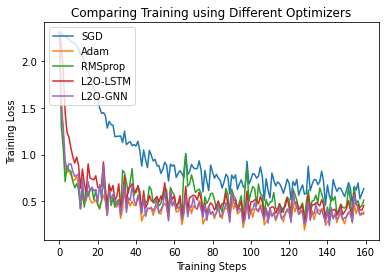

In [28]:
plt.xlabel('Training Steps')
plt.ylabel('Training Loss')
plt.title('Comparing Training using Different Optimizers')
for i in range(num_opts + 2):
    plt.plot(his[i], label=names[i])

plt.legend(loc="upper left")
plt.show()